In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "../../Dataset/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [6]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])

In [7]:
x_train.shape

(1084578, 40)

In [8]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_validation_scaled = scaler.fit_transform(x_validation)
x_test_scaled = scaler.transform(x_test)

In [9]:
pca = PCA()
x_train_pca = pca.fit_transform(x_train_scaled)
x_validation_pca = pca.transform(x_validation_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [10]:
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # 95% of variance

x_train_pca = x_train_pca[:, :n_components]
x_validation_pca = x_validation_pca[:, :n_components]
x_test_pca = x_test_pca[:, :n_components]

In [12]:
x_train_pca.shape

(1084578, 31)

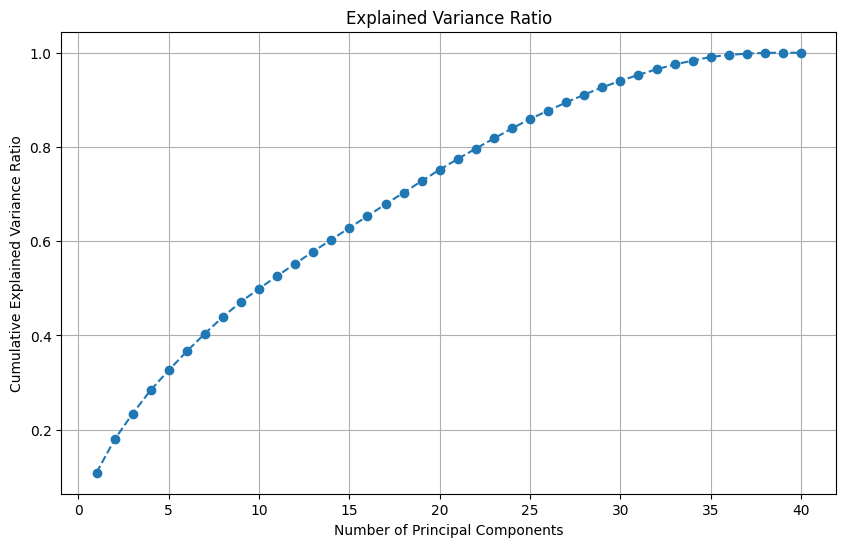

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [16]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), --> 1.0 is what we want
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train_pca, y_train), num_boost_round=500)
    
    preds = gbm.predict(x_validation_pca)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    #choose the metric you want to optimized
    
    match optimisation_metric:
        case "auc":
            return auc
        case "recall":
            return recall
        case "precision":
            return precision
        case "f1":
            return f1
        case _:
            return auc
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-06 11:39:12,979] A new study created in memory with name: no-name-d47f241a-d5f7-468d-a10a-56d7736c57ed


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:40:33,921] Trial 0 finished with value: 0.9353582357290668 and parameters: {'num_leaves': 143, 'lambda_l1': 1.4752896183584259, 'lambda_l2': 0.0010882157392993735, 'bagging_fraction': 0.9534888401596813, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 0 with value: 0.9353582357290668.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:41:54,930] Trial 1 finished with value: 0.9374164557616953 and parameters: {'num_leaves': 147, 'lambda_l1': 0.6560920108012888, 'lambda_l2': 3.93654839671703e-06, 'bagging_fraction': 0.9012700891769322, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 1 with value: 0.9374164557616953.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:42:34,729] Trial 2 finished with value: 0.9308244974465454 and parameters: {'num_leaves': 27, 'lambda_l1': 0.07194399825454463, 'lambda_l2': 1.091774423841589e-05, 'bagging_fraction': 0.7824469397667946, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 1 with value: 0.9374164557616953.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:43:00,813] Trial 3 finished with value: 0.9420415564841463 and parameters: {'num_leaves': 10, 'lambda_l1': 0.4420624319109073, 'lambda_l2': 3.317551488301027e-08, 'bagging_fraction': 0.7351092300522313, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 3 with value: 0.9420415564841463.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:43:42,513] Trial 4 finished with value: 0.8798321670886948 and parameters: {'num_leaves': 53, 'lambda_l1': 3.3436147557887307e-06, 'lambda_l2': 6.569169281704483e-05, 'bagging_fraction': 0.5485664385842746, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 3 with value: 0.9420415564841463.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:44:09,784] Trial 5 finished with value: 0.9433090056732036 and parameters: {'num_leaves': 25, 'lambda_l1': 7.15928720439643e-05, 'lambda_l2': 0.002211645220028005, 'bagging_fraction': 0.7015531570103847, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:45:21,558] Trial 6 finished with value: 0.9178692598026876 and parameters: {'num_leaves': 167, 'lambda_l1': 2.0432067544409297e-06, 'lambda_l2': 0.006497149282371044, 'bagging_fraction': 0.45799000134545104, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:46:39,470] Trial 7 finished with value: 0.9274514823965208 and parameters: {'num_leaves': 161, 'lambda_l1': 0.015261109471343806, 'lambda_l2': 4.805139920499679e-08, 'bagging_fraction': 0.8192008036330176, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:47:27,589] Trial 8 finished with value: 0.9169416090311936 and parameters: {'num_leaves': 57, 'lambda_l1': 8.43719515759818e-08, 'lambda_l2': 0.0008637860419844701, 'bagging_fraction': 0.9271498200215085, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:48:23,377] Trial 9 finished with value: 0.9250717746384417 and parameters: {'num_leaves': 91, 'lambda_l1': 0.0014169550460814125, 'lambda_l2': 9.606423092022948e-06, 'bagging_fraction': 0.5446698800284004, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:49:18,345] Trial 10 finished with value: 0.9396215433724899 and parameters: {'num_leaves': 98, 'lambda_l1': 0.00011290238474801154, 'lambda_l2': 0.8009871100233429, 'bagging_fraction': 0.6594844201647352, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2023-11-06 11:50:48,411] Trial 11 finished with value: 0.9387096108702312 and parameters: {'num_leaves': 252, 'lambda_l1': 9.20684509379279, 'lambda_l2': 1.1430627618452314e-08, 'bagging_fraction': 0.6839657832770546, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 5 with value: 0.9433090056732036.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:51:04,471] Trial 12 finished with value: 0.9439249107715333 and parameters: {'num_leaves': 2, 'lambda_l1': 0.0007888328445074065, 'lambda_l2': 2.687762056092678e-07, 'bagging_fraction': 0.7631288821108051, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 12 with value: 0.9439249107715333.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:51:26,595] Trial 13 finished with value: 0.9487838753261812 and parameters: {'num_leaves': 5, 'lambda_l1': 0.00029730110564318076, 'lambda_l2': 0.03733307786735561, 'bagging_fraction': 0.8150858011410145, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 13 with value: 0.9487838753261812.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:51:49,631] Trial 14 finished with value: 0.9566770116164558 and parameters: {'num_leaves': 5, 'lambda_l1': 0.006509817461673735, 'lambda_l2': 0.2805076968016368, 'bagging_fraction': 0.8511394109566524, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:53:19,751] Trial 15 finished with value: 0.9287584182792993 and parameters: {'num_leaves': 228, 'lambda_l1': 0.008568782010893556, 'lambda_l2': 0.3248220481603444, 'bagging_fraction': 0.9984913280324741, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:54:07,796] Trial 16 finished with value: 0.9392867660687104 and parameters: {'num_leaves': 57, 'lambda_l1': 0.003546398279984095, 'lambda_l2': 5.566305290712714, 'bagging_fraction': 0.8360106038161768, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:55:29,243] Trial 17 finished with value: 0.9306033501307781 and parameters: {'num_leaves': 197, 'lambda_l1': 0.05497478379100558, 'lambda_l2': 0.02816205899788832, 'bagging_fraction': 0.8603861100784372, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:56:22,601] Trial 18 finished with value: 0.934742930981298 and parameters: {'num_leaves': 98, 'lambda_l1': 0.00031991813447648207, 'lambda_l2': 0.017066173179910084, 'bagging_fraction': 0.8826431589530489, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:57:09,002] Trial 19 finished with value: 0.9342710008629767 and parameters: {'num_leaves': 76, 'lambda_l1': 2.8202549847163533e-05, 'lambda_l2': 0.08244790237961623, 'bagging_fraction': 0.7961471870428153, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:57:44,764] Trial 20 finished with value: 0.9428515385456715 and parameters: {'num_leaves': 31, 'lambda_l1': 0.001686775139302535, 'lambda_l2': 3.970216458381648, 'bagging_fraction': 0.8617282900618944, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:58:07,352] Trial 21 finished with value: 0.9444049729110912 and parameters: {'num_leaves': 9, 'lambda_l1': 0.0008664195326332289, 'lambda_l2': 0.1744456664976056, 'bagging_fraction': 0.7771009587448321, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:58:27,384] Trial 22 finished with value: 0.95371755623702 and parameters: {'num_leaves': 4, 'lambda_l1': 0.00036565647879933786, 'lambda_l2': 0.36224446237779434, 'bagging_fraction': 0.8172645586731175, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:59:01,220] Trial 23 finished with value: 0.9436069978607873 and parameters: {'num_leaves': 36, 'lambda_l1': 0.000243290260507095, 'lambda_l2': 0.8685897655239766, 'bagging_fraction': 0.8314257127533677, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 11:59:40,818] Trial 24 finished with value: 0.9420582025678849 and parameters: {'num_leaves': 49, 'lambda_l1': 0.018334791454574815, 'lambda_l2': 0.07025989135927523, 'bagging_fraction': 0.9041005097837604, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:00:33,767] Trial 25 finished with value: 0.9280234254605835 and parameters: {'num_leaves': 115, 'lambda_l1': 3.283980923030403e-05, 'lambda_l2': 0.009065566120068992, 'bagging_fraction': 0.7417000003220129, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:01:21,752] Trial 26 finished with value: 0.9366572306112421 and parameters: {'num_leaves': 75, 'lambda_l1': 0.0028205760729506993, 'lambda_l2': 1.5522630351877624, 'bagging_fraction': 0.8191055888895421, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:01:37,670] Trial 27 finished with value: 0.9424277456268828 and parameters: {'num_leaves': 2, 'lambda_l1': 0.00036200488635488605, 'lambda_l2': 9.630256619003248, 'bagging_fraction': 0.8657651159150033, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:02:07,442] Trial 28 finished with value: 0.9416861489519952 and parameters: {'num_leaves': 19, 'lambda_l1': 0.0053356170244504625, 'lambda_l2': 0.2868368118039826, 'bagging_fraction': 0.9441634748518798, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:02:44,334] Trial 29 finished with value: 0.9469536247747867 and parameters: {'num_leaves': 42, 'lambda_l1': 0.04864260622511791, 'lambda_l2': 0.05540534021415807, 'bagging_fraction': 0.9820075912480215, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:03:44,580] Trial 30 finished with value: 0.9318550264732767 and parameters: {'num_leaves': 120, 'lambda_l1': 0.20736487442453252, 'lambda_l2': 0.003046137505537353, 'bagging_fraction': 0.9279866630384254, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:04:22,289] Trial 31 finished with value: 0.9376803916992694 and parameters: {'num_leaves': 39, 'lambda_l1': 0.035984833383147175, 'lambda_l2': 0.04111272509505499, 'bagging_fraction': 0.9791366006990041, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:04:49,236] Trial 32 finished with value: 0.9370647049102345 and parameters: {'num_leaves': 19, 'lambda_l1': 0.1115678032684587, 'lambda_l2': 0.1111249399854336, 'bagging_fraction': 0.948113693436474, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:05:33,626] Trial 33 finished with value: 0.9326469434406462 and parameters: {'num_leaves': 69, 'lambda_l1': 0.01080393908487903, 'lambda_l2': 0.017705930772690205, 'bagging_fraction': 0.966559875675936, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:06:02,780] Trial 34 finished with value: 0.9459360305737802 and parameters: {'num_leaves': 21, 'lambda_l1': 0.637387825073404, 'lambda_l2': 0.31945229354127247, 'bagging_fraction': 0.9037091165330725, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:06:41,627] Trial 35 finished with value: 0.9416663373834802 and parameters: {'num_leaves': 40, 'lambda_l1': 0.026297827833424662, 'lambda_l2': 1.592743498134456, 'bagging_fraction': 0.9902792729253134, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:06:57,954] Trial 36 finished with value: 0.94305194647842 and parameters: {'num_leaves': 2, 'lambda_l1': 0.16533965486870694, 'lambda_l2': 0.044873036968961735, 'bagging_fraction': 0.9156907351884249, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:07:27,127] Trial 37 finished with value: 0.9430510732412402 and parameters: {'num_leaves': 17, 'lambda_l1': 0.0031843263731692857, 'lambda_l2': 0.006321285438330488, 'bagging_fraction': 0.8832087142474352, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:08:01,254] Trial 38 finished with value: 0.9302875111583339 and parameters: {'num_leaves': 29, 'lambda_l1': 0.07035249514485545, 'lambda_l2': 0.00022046192472744588, 'bagging_fraction': 0.957829582091254, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:08:42,494] Trial 39 finished with value: 0.9382159862657256 and parameters: {'num_leaves': 53, 'lambda_l1': 0.008794631433834637, 'lambda_l2': 0.0012831363767828617, 'bagging_fraction': 0.8065726823695558, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:10:06,275] Trial 40 finished with value: 0.9438313652386544 and parameters: {'num_leaves': 143, 'lambda_l1': 1.8949109993217885, 'lambda_l2': 0.4775325624550973, 'bagging_fraction': 0.8423602058329107, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:10:37,346] Trial 41 finished with value: 0.9453744299125648 and parameters: {'num_leaves': 19, 'lambda_l1': 0.5277405576103855, 'lambda_l2': 0.16388597184031028, 'bagging_fraction': 0.9023234134410454, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:11:13,647] Trial 42 finished with value: 0.9418788614820973 and parameters: {'num_leaves': 43, 'lambda_l1': 0.3305778231060197, 'lambda_l2': 0.34082260923564556, 'bagging_fraction': 0.8881360075523289, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:11:42,316] Trial 43 finished with value: 0.9464348127353783 and parameters: {'num_leaves': 14, 'lambda_l1': 1.7848216625715836, 'lambda_l2': 2.4248737526169646, 'bagging_fraction': 0.9298857636747839, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:12:10,305] Trial 44 finished with value: 0.9476585454881254 and parameters: {'num_leaves': 14, 'lambda_l1': 1.9508259197513056, 'lambda_l2': 2.1106754979669766, 'bagging_fraction': 0.9256232474776163, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:12:54,443] Trial 45 finished with value: 0.936877995885743 and parameters: {'num_leaves': 63, 'lambda_l1': 0.029697681143798418, 'lambda_l2': 0.8927630741143661, 'bagging_fraction': 0.9675867121655846, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:13:24,163] Trial 46 finished with value: 0.9436729818451808 and parameters: {'num_leaves': 29, 'lambda_l1': 0.00128582330549892, 'lambda_l2': 2.639084891397876, 'bagging_fraction': 0.7879358671143069, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:13:55,015] Trial 47 finished with value: 0.9471874886069837 and parameters: {'num_leaves': 11, 'lambda_l1': 6.31077843972745, 'lambda_l2': 0.10536121393585905, 'bagging_fraction': 0.9987924192562911, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:15:28,571] Trial 48 finished with value: 0.9405660585370176 and parameters: {'num_leaves': 180, 'lambda_l1': 5.940304741605754, 'lambda_l2': 9.586984742504928, 'bagging_fraction': 0.8400734452761236, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:15:56,029] Trial 49 finished with value: 0.9484088745348102 and parameters: {'num_leaves': 11, 'lambda_l1': 3.060798742630087, 'lambda_l2': 0.7731563065574172, 'bagging_fraction': 0.9388361175753015, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:16:44,813] Trial 50 finished with value: 0.9414686583169184 and parameters: {'num_leaves': 83, 'lambda_l1': 1.049920014623583, 'lambda_l2': 0.7714095017574447, 'bagging_fraction': 0.7596991232418828, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:17:13,177] Trial 51 finished with value: 0.9512988529811336 and parameters: {'num_leaves': 9, 'lambda_l1': 8.852666190900576, 'lambda_l2': 1.647785171601457, 'bagging_fraction': 0.9987098751349766, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:17:32,856] Trial 52 finished with value: 0.9531947054756555 and parameters: {'num_leaves': 3, 'lambda_l1': 3.0443026668571167, 'lambda_l2': 4.221581091407203, 'bagging_fraction': 0.9395865449216825, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:17:54,877] Trial 53 finished with value: 0.9519224534821096 and parameters: {'num_leaves': 5, 'lambda_l1': 8.622185399088897, 'lambda_l2': 0.7320271033266144, 'bagging_fraction': 0.8639814625538944, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:18:30,255] Trial 54 finished with value: 0.941947301446059 and parameters: {'num_leaves': 28, 'lambda_l1': 4.353716605604288, 'lambda_l2': 5.2366700028101585, 'bagging_fraction': 0.8615546598768051, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:18:51,380] Trial 55 finished with value: 0.9521405444677479 and parameters: {'num_leaves': 5, 'lambda_l1': 9.195136106068789, 'lambda_l2': 0.1728805158208922, 'bagging_fraction': 0.8065297426167793, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:19:11,077] Trial 56 finished with value: 0.9544218220224743 and parameters: {'num_leaves': 4, 'lambda_l1': 8.175298834443664, 'lambda_l2': 0.18525218690242112, 'bagging_fraction': 0.8035191749931965, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:19:42,356] Trial 57 finished with value: 0.9393108346684764 and parameters: {'num_leaves': 26, 'lambda_l1': 0.9628903857070561, 'lambda_l2': 0.2818288725994959, 'bagging_fraction': 0.8051466064080126, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:19:55,910] Trial 58 finished with value: 0.942951305893456 and parameters: {'num_leaves': 2, 'lambda_l1': 3.0932037421729035, 'lambda_l2': 0.15152540861317262, 'bagging_fraction': 0.7223683921397193, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:20:36,258] Trial 59 finished with value: 0.9421422516464342 and parameters: {'num_leaves': 47, 'lambda_l1': 0.3751887624553607, 'lambda_l2': 3.9962119857463354, 'bagging_fraction': 0.7782033173751736, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:21:18,386] Trial 60 finished with value: 0.9461465353114193 and parameters: {'num_leaves': 37, 'lambda_l1': 9.321280063375578, 'lambda_l2': 0.6658075507226509, 'bagging_fraction': 0.8277489680579311, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:21:45,595] Trial 61 finished with value: 0.9508733135879854 and parameters: {'num_leaves': 11, 'lambda_l1': 9.297230833352499, 'lambda_l2': 1.4855331294695246, 'bagging_fraction': 0.8548219733745838, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:22:09,487] Trial 62 finished with value: 0.9513856855031929 and parameters: {'num_leaves': 7, 'lambda_l1': 4.787328626161749, 'lambda_l2': 1.2272146445652448, 'bagging_fraction': 0.8857179419253787, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:22:25,201] Trial 63 finished with value: 0.9427751848697686 and parameters: {'num_leaves': 2, 'lambda_l1': 3.0487412104520986, 'lambda_l2': 0.21124097771534356, 'bagging_fraction': 0.8781015779805883, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:22:56,438] Trial 64 finished with value: 0.9421926810935637 and parameters: {'num_leaves': 25, 'lambda_l1': 1.4143966237091479, 'lambda_l2': 0.0785064079275491, 'bagging_fraction': 0.8463668700635771, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:23:32,402] Trial 65 finished with value: 0.9424416628444349 and parameters: {'num_leaves': 33, 'lambda_l1': 3.570021710079423, 'lambda_l2': 0.38529934557113743, 'bagging_fraction': 0.8053096747871192, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:24:03,883] Trial 66 finished with value: 0.9345047009632024 and parameters: {'num_leaves': 22, 'lambda_l1': 1.082814810507444, 'lambda_l2': 0.02666286540389798, 'bagging_fraction': 0.8789430760959075, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:25:43,398] Trial 67 finished with value: 0.9426052310836633 and parameters: {'num_leaves': 222, 'lambda_l1': 4.978257775283736, 'lambda_l2': 4.322145409100787, 'bagging_fraction': 0.8232655860951693, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:26:06,301] Trial 68 finished with value: 0.9521955038327471 and parameters: {'num_leaves': 8, 'lambda_l1': 0.7748053638528991, 'lambda_l2': 1.1341693200519263, 'bagging_fraction': 0.7903789335047987, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:26:32,483] Trial 69 finished with value: 0.9441891195957259 and parameters: {'num_leaves': 16, 'lambda_l1': 0.6552820462673401, 'lambda_l2': 0.5404653111445542, 'bagging_fraction': 0.7875572599856833, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:27:17,919] Trial 70 finished with value: 0.9403909744824814 and parameters: {'num_leaves': 60, 'lambda_l1': 2.254322056639004, 'lambda_l2': 0.17492324668617074, 'bagging_fraction': 0.7652920479515289, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:27:42,891] Trial 71 finished with value: 0.9512102739847145 and parameters: {'num_leaves': 8, 'lambda_l1': 5.004818256193133, 'lambda_l2': 1.0978816613205125, 'bagging_fraction': 0.8248535354349328, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:28:06,583] Trial 72 finished with value: 0.9516274630473316 and parameters: {'num_leaves': 7, 'lambda_l1': 9.758974254956941, 'lambda_l2': 0.5112462275829821, 'bagging_fraction': 0.8509368226707693, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:28:36,790] Trial 73 finished with value: 0.9415022233710142 and parameters: {'num_leaves': 24, 'lambda_l1': 0.9918464526148507, 'lambda_l2': 0.4405167431047992, 'bagging_fraction': 0.8028949326635021, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:29:19,641] Trial 74 finished with value: 0.9451199904293205 and parameters: {'num_leaves': 34, 'lambda_l1': 9.797745664938903, 'lambda_l2': 0.08245023968927914, 'bagging_fraction': 0.8485666506384054, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:29:36,055] Trial 75 finished with value: 0.9427357800420333 and parameters: {'num_leaves': 2, 'lambda_l1': 0.2717216882597989, 'lambda_l2': 2.919022287752644, 'bagging_fraction': 0.8348193909095964, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:30:04,114] Trial 76 finished with value: 0.9419478472192961 and parameters: {'num_leaves': 17, 'lambda_l1': 0.4875806677593812, 'lambda_l2': 0.19621950423605147, 'bagging_fraction': 0.8146244952583217, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:30:22,221] Trial 77 finished with value: 0.9484517723112645 and parameters: {'num_leaves': 9, 'lambda_l1': 2.562824072679359, 'lambda_l2': 0.5702958174873531, 'bagging_fraction': 0.8628353322726311, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:30:51,352] Trial 78 finished with value: 0.9378749598583784 and parameters: {'num_leaves': 48, 'lambda_l1': 0.17113475708690376, 'lambda_l2': 7.849836114334095, 'bagging_fraction': 0.7943354777884777, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:31:12,571] Trial 79 finished with value: 0.944566030593428 and parameters: {'num_leaves': 21, 'lambda_l1': 0.10798229826634886, 'lambda_l2': 3.041271457207958, 'bagging_fraction': 0.914157455593561, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:31:34,949] Trial 80 finished with value: 0.9361383639945099 and parameters: {'num_leaves': 34, 'lambda_l1': 1.866651192443008, 'lambda_l2': 0.04900546606283468, 'bagging_fraction': 0.7480232790063324, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:31:54,140] Trial 81 finished with value: 0.948357571850501 and parameters: {'num_leaves': 11, 'lambda_l1': 4.7357194068739705, 'lambda_l2': 1.139024409247797, 'bagging_fraction': 0.8858534569433891, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:32:11,628] Trial 82 finished with value: 0.9514585462303771 and parameters: {'num_leaves': 7, 'lambda_l1': 4.097164964834168, 'lambda_l2': 1.4720249829069108, 'bagging_fraction': 0.8925930708442111, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:32:31,255] Trial 83 finished with value: 0.9452201398183709 and parameters: {'num_leaves': 16, 'lambda_l1': 1.3976730781234536, 'lambda_l2': 1.914349068962122, 'bagging_fraction': 0.849892295376796, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:32:44,434] Trial 84 finished with value: 0.9432039443250172 and parameters: {'num_leaves': 2, 'lambda_l1': 2.735023399903743, 'lambda_l2': 0.30146340331242544, 'bagging_fraction': 0.9010056176193229, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:33:04,775] Trial 85 finished with value: 0.9454476181036914 and parameters: {'num_leaves': 23, 'lambda_l1': 0.7931354692581731, 'lambda_l2': 0.12170570909935281, 'bagging_fraction': 0.8683471096338591, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:33:54,185] Trial 86 finished with value: 0.9409902334970726 and parameters: {'num_leaves': 130, 'lambda_l1': 6.354235533500392, 'lambda_l2': 5.462687730340765, 'bagging_fraction': 0.8320470285549687, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:34:09,865] Trial 87 finished with value: 0.9508034000362832 and parameters: {'num_leaves': 6, 'lambda_l1': 1.4916494555873128, 'lambda_l2': 0.6733971389948151, 'bagging_fraction': 0.8129048568987941, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:34:28,852] Trial 88 finished with value: 0.9478615731324129 and parameters: {'num_leaves': 15, 'lambda_l1': 0.5586185255537911, 'lambda_l2': 1.1670955512741894, 'bagging_fraction': 0.7798095763077032, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:34:54,314] Trial 89 finished with value: 0.9465483881460672 and parameters: {'num_leaves': 31, 'lambda_l1': 6.630482949167827, 'lambda_l2': 1.890854533909064, 'bagging_fraction': 0.8691901324079336, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:35:21,206] Trial 90 finished with value: 0.9445408158698632 and parameters: {'num_leaves': 41, 'lambda_l1': 3.6619218188707094, 'lambda_l2': 0.22862465709284138, 'bagging_fraction': 0.8377564969583882, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:35:39,064] Trial 91 finished with value: 0.951976594187253 and parameters: {'num_leaves': 7, 'lambda_l1': 4.824501505780346, 'lambda_l2': 1.0751341013286644, 'bagging_fraction': 0.8936313684503157, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:35:58,788] Trial 92 finished with value: 0.953096193406317 and parameters: {'num_leaves': 6, 'lambda_l1': 2.4089672495418837, 'lambda_l2': 0.40299011583009586, 'bagging_fraction': 0.8981555825500896, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:36:18,127] Trial 93 finished with value: 0.9442121512263415 and parameters: {'num_leaves': 12, 'lambda_l1': 2.158834968243466, 'lambda_l2': 0.4469214635315367, 'bagging_fraction': 0.9194951394487839, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:36:39,639] Trial 94 finished with value: 0.9467019687350527 and parameters: {'num_leaves': 17, 'lambda_l1': 8.045157108206967, 'lambda_l2': 0.8771610388996731, 'bagging_fraction': 0.8548428793996594, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:37:01,841] Trial 95 finished with value: 0.942168885380416 and parameters: {'num_leaves': 27, 'lambda_l1': 1.3120129416586694, 'lambda_l2': 0.13139306724407837, 'bagging_fraction': 0.9370173978390375, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:37:18,755] Trial 96 finished with value: 0.955353620670572 and parameters: {'num_leaves': 5, 'lambda_l1': 9.381455298915919, 'lambda_l2': 0.29890080775044325, 'bagging_fraction': 0.9095645223573886, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:37:38,982] Trial 97 finished with value: 0.941375603979953 and parameters: {'num_leaves': 19, 'lambda_l1': 0.3693578314440223, 'lambda_l2': 0.06285085641846988, 'bagging_fraction': 0.904891917051988, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:37:51,129] Trial 98 finished with value: 0.9423077300919933 and parameters: {'num_leaves': 2, 'lambda_l1': 2.7920498879477886, 'lambda_l2': 0.26793340273968136, 'bagging_fraction': 0.9130666260978829, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 14 with value: 0.9566770116164558.


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 12:38:27,401] Trial 99 finished with value: 0.9333255033066217 and parameters: {'num_leaves': 107, 'lambda_l1': 0.8043855070782868, 'lambda_l2': 0.09235176416648984, 'bagging_fraction': 0.9427872508751374, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 14 with value: 0.9566770116164558.


In [17]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"
best_params['num_boost_round'] = 500

gbm = lgb.train(best_params, lgb.Dataset(x_train_pca, y_train))#, valid_sets=[lgb.Dataset(x_validation_pca, y_validation_pca)])

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


Accuracy: 0.9866436762733667
Recall: 0.03205128205128205
Precision: 0.014619883040935672
F1 Score: 0.020080321285140562
AUC: 0.8532514506374489


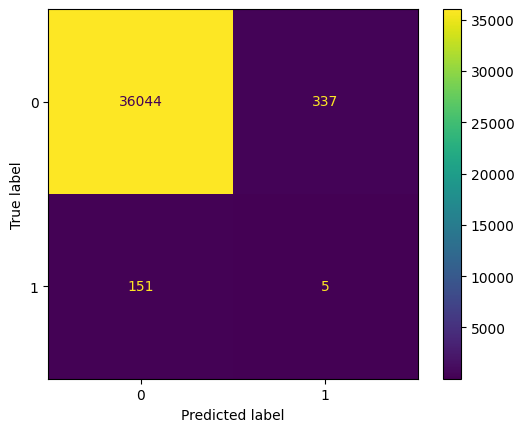

In [18]:
y_pred = gbm.predict(x_test_pca)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

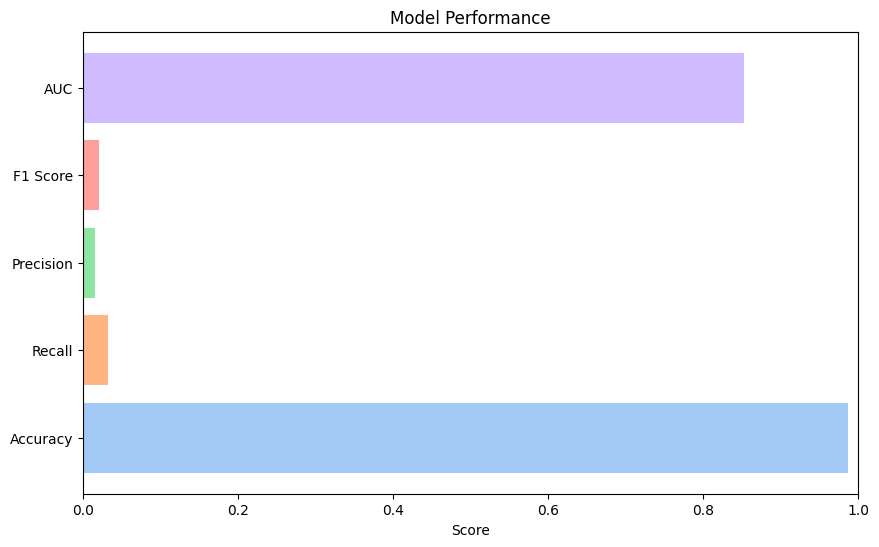

In [19]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [20]:
lst = range(0, len(x_train_pca[0]))
lst_str = [format(x, '02d') for x in lst]
importance = pd.DataFrame({'feature': lst_str ,'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

   feature  importance
4       04         167
2       02         161
5       05         102
30      30          90
7       07          88
8       08          87
3       03          85
0       00          79
6       06          78
1       01          77
25      25          76
22      22          73
18      18          67
24      24          64
20      20          59
29      29          57
12      12          54
23      23          54
19      19          52
11      11          51
26      26          49
9       09          46
27      27          46
28      28          46
17      17          39
10      10          34
15      15          34
21      21          26
13      13          25
14      14          18
16      16          16


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


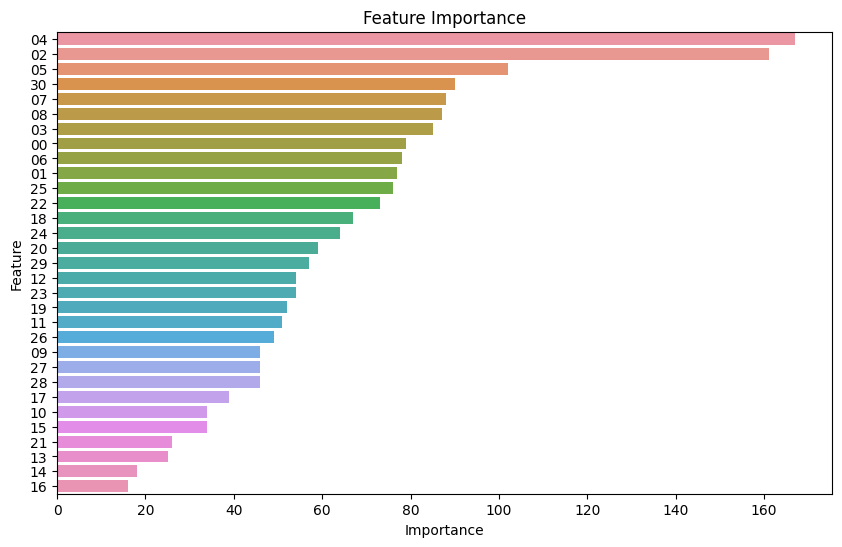

In [21]:
feature_importance = gbm.feature_importance()
features = lst_str
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

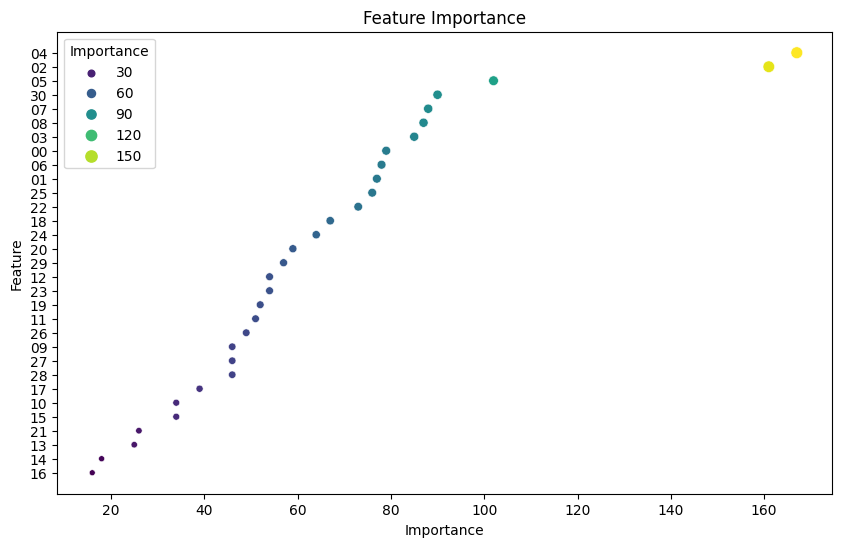

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [23]:
#AUC OPTIMIZED PCA
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_PCA_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_PCAfactors_aucoptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_PCAfactors_aucoptimized.txt')